<a href="https://colab.research.google.com/github/mckenzie0805/PRA3024/blob/main/Mckenzie_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# some data-handling functions to download/import.
# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict

def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf

# gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [3]:
# load the data samples
x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


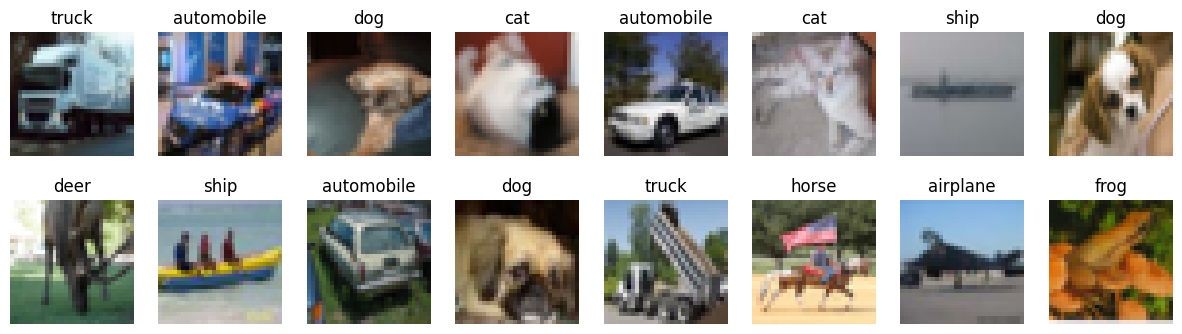

In [4]:
# show some random images from train, and their labels
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5
y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers import LeakyReLU

In [8]:
# from cifar-10 we load 60000 images in 10 classes, 6000 per class (32x32 pixels)
# gets reshaped into -> (number_of_images, height, width, channels), which is (N, 32, 32, 3).
# i.e. train images in 50 000 and test images are 10 000
# labels are one hot coded, so as not to be a single integer value
# lets build my model

 # STUDENT CODE HERE #

from tensorflow.keras.layers import BatchNormalization

def make_model():

    model = Sequential()

    # 1st convolutional block

    # building my convolutional neural network
    # first, make a CNN layer with some small kernels to learn some basic features, with Conv2D
    # then, add a Pooling layer to pick up the relevant kernels
    # then, Flatten it and add some fully-connected (Dense) normal NN layers, to learn the relevant combinations of low-level kernel features
    # finally, some regularisation is advised, using a Dropout layer, to avoid local minima
    # make sure the output is of the same shape as the number of labels we have,
    # and the input is the same as the figures (which now have a 3rd dimension - color!)

    # sources used to better understand the various parts of a cnn:
    # https://www.v7labs.com/blog/image-recognition-guide
    # sigmoid relu debate:
    # https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks
    # possible optimizers:
    # https://medium.com/@astitwa15108824/comparative-analysis-of-adam-optimizer-and-its-variants-adamax-rmsprop-and-adagrad-addressing-02889adc8735

    # each of the convolutional blocks is designed to learn increasingly abstract features from the input images
    # 1st block extracting features using Conv2D layers with small 3x3 filters
    # use 'same' for padding to ensure spatial dimensions remain constant, aka input and output has same spatial dimensions
    # activation set to sigmoid, also tried using relu so this is more experimental, and was changed througout
    # apply batch normalization to normalize activations to speed up training
    # pooling to reduce spatial dimensions - to lower the computational cost
    # dropout to set a fraction of the input units to zero and prevents overfitting

    # the first block starts with a 32 filter convolution, then increases to 64 filter
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('sigmoid'))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # 2nd convolutional block
    # deepens the network by starting from 64 and increasing to 128 filters
    # more filters for more complex and abstract features deeper into the network

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # 3rd convolutional block
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # after doing 3 convolutional blocks, the output feature map now gets flattened(1D) and passed through dense layers (512 units)
    # that combine the extracted features to perform classification
    # relu, commonly used for dense layers, efficient
    # higher dropout to continue to counteract overfitting
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # output layer
    model.add(Dense(10))

    # ensure normalized probabilities over the 10 classes
    model.add(Activation("softmax"))

    return model


In [9]:
# STUDENT CODE HERE #

# change the parameters below to perform a better training
# batch size: number of training samples used to compute gradient each step up
# epochs: one epoch is one full pass through the training set
INIT_LR = 5e-3
BATCH_SIZE = 124
EPOCHS = 70

# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
K.clear_session()
model = make_model()

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=INIT_LR),
    metrics=['accuracy']
)

# fit model
model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
)

# save weights to file to avoid re-training
model.save_weights("myweights.weights.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
323/323 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.3505 - loss: 2.0522 - val_accuracy: 0.1109 - val_loss: 3.5534
Epoch 2/70


KeyboardInterrupt: 

# Commenting on the results this far and decisions made above:

side notes for myself:
- sharper activation function good idea
- dense layers till relu
- load weights from file (can call without model.fit)
- 3rd convolution layer was a good idea
- upped the epocs and went back down
- highest val accuracy observed: 83.64 ≈ 84 %

## My choices:

- I trained this set on a batch size of 124 and 70 epochs. I played around with this number, but increasing it further caused a plateau in the value accuracy and loss, or even sometimes a decrease.
- For activation functions I tested both Sigmoid and ReLU. Sigmoid can work for smaller datasets, but it sometimes leads to vanishing gradients in deeper architectures (see reference above on this). ReLU typically converges faster and often yields better accuracy. However, experimenting with both provided insight into how each function affects training dynamics.
- I also tested Adamax versus Adam and SGD (references above on this too). Adam and Adamax are adaptive optimizers that often converge more quickly and handle varying learning rates internally. Adamax, in particular, can sometimes be more stable with sparse gradients or certain layer setups. In contrast, SGD (with momentum) can yield good results but may require more careful learning-rate tuning.

## In the results section we have:

Training Loss ('loss') - Average value of your loss function computed on the training data. A lower loss indicates the model is fitting the training data better.

Training Accuracy ('accuracy') - The fraction of correct predictions on the training data.

Validation Loss ('val_loss') - Loss metric but computed on the validation set. A lower validation loss indicates better generalization.

Validation Accuracy ('val_accuracy') - The fraction of correct predictions on the validation set.

Final Training Accuracy ≈ 96.43%

Final Training Loss ≈ 0.1027

Final Validation Accuracy ≈ 83.64%

Final Validation Loss ≈ 0.693

So to summarize, on unseen validation data, the model correctly classifies ~83.64% of the images. Because the training accuracy is higher than the validation accuracy, the model is overfitting to some extent (which is sort of expected on this relatively small dataset, CIFAR-10). However vaidation loss remains less than training loss. Overfitting means it performs very well on the data it has seen (training set) but less well on new data (validation set).

Overall, achieving ~84% on CIFAR-10 with a relatively straightforward CNN is not a bad starting point, but there is still room for improvement

This section is referenced at the link: https://medium.com/@frederik.vl/interpreting-training-validation-accuracy-and-loss-cf16f0d5329f
and https://stackoverflow.com/questions/60475162/why-is-my-neural-network-validation-accuracy-higher-than-my-training-accuracy-an


In [ ]:
model.load_weights("myweights.weights.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


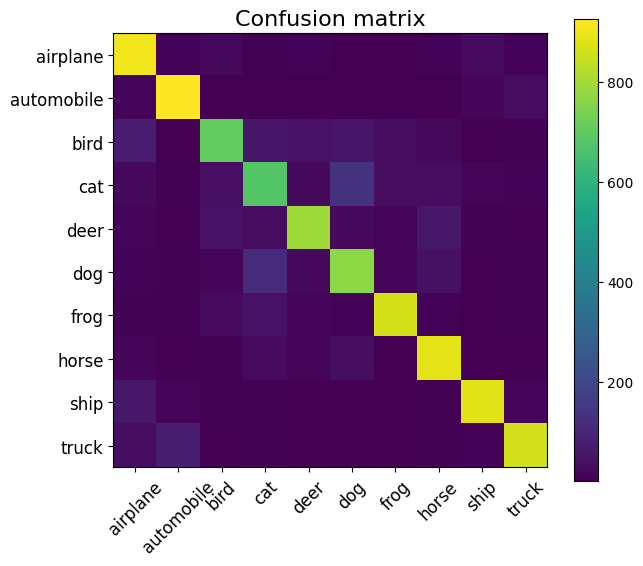

Test accuracy: 0.8265


In [ ]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

# Comments on Confusion matrix:

Reference used: https://medium.com/@astitwa15108824/comparative-analysis-of-adam-optimizer-and-its-variants-adamax-rmsprop-and-adagrad-addressing-02889adc8735

The diagonal (top-left to the bottom-right) indicates that, for most classes, the model is correctly predicting the true label a high proportion of the time. This is a good sign that the model has learned to distinguish the general characteristics of each category (airplane, automobile, bird, etc.).

Common Misclassifications:
- Animals: You might notice that classes like cat, bird, deer, and frog show some off-diagonal confusion among each other. This suggests that the model occasionally struggles with fine-grained distinctions between animals, which can look similar (especially at a resolution of 32×32 which really is not great).
- Vehicles: Classes like automobile and airplane specifically may sometimes be confused, likely because they share visual features such as similar shapes or backgrounds.

As stated at (https://www.geeksforgeeks.org/confusion-matrix-machine-learning/): "Accuracy measures how often the model’s predictions are correct overall. It gives a general idea of how well the model is performing." A perfect model would thus have an accuracy of 100%. I would interpret an accuracy of 82.65% (rounded up to 83 of course) to be relatively good.

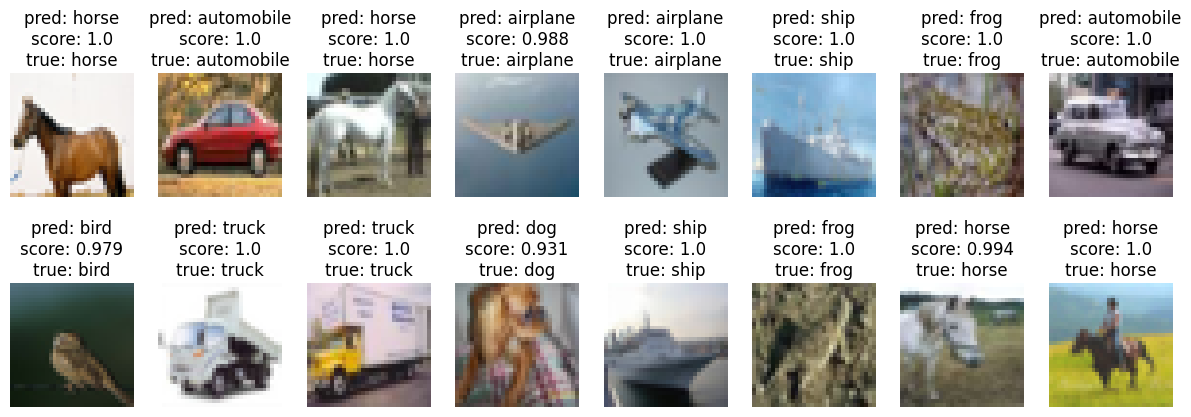

In [ ]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


